<p style="text-align:right;">Mario Stanke, University of Greifswald, Germany</p>

# Solution to Exercise Set 1, Exercise 2 - A Quadratic Model

In this notebook we extend the solution from the previous exercise (different loss) to a quadratic prediction function 

$$t = h_{\pmb{\theta}}(x) := \theta_0 + \theta_1 x + \theta_2 x^2,$$

where $x = x_1 = $ temperature. The loss function remains $ \ell(y, t) = 5 \cdot \texttt{relu}(y-t) + \texttt{relu}(t-y)$.

**Instructions:**

 1. Run the whole notebook to produce the results from the linear fit at first: Kernel -> Restart & Run All
 2. Skip to **1. Compute Data Matrix with Squares** and implement the extension of the data matrix. Rerun notebook cells from there on.

In [1]:
# First import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

### Implement $\ell(y, t)$ with tensorflow functions.

In [2]:
def ell(y, t):
    '''
        Input: y and t are vectors of the same size.
        Output: vector of 5 * relu(y-t) + relu(t-y) applied to each component of y and t
    '''
    return 5 * tf.nn.relu(y - t) + tf.nn.relu(t - y)

In [3]:
# load the training data from the table file to a pandas data frame
df = pd.read_csv("bikes-summerdays.tbl", sep='\s+')
df['count'] = df['count'].astype(float) # convert count data to floats
m, n_cols = df.shape # training set size and number of columns 

In [4]:
def scatterplot_rentals():
    ''' Plot the bike rental counts versus the temperature.'''
    _, ax = plt.subplots()
    ax.scatter(df["temp"], df["count"])
    plt.title("bike rentals versus temperature")
    plt.xlabel('temperature [' + r'$^\circ$' + 'C]')
    plt.ylabel('rental count per hour');
    return ax

## Create *original* data matrix $X$ and response vector $y$

In [5]:
# extract response vector
y_train = np.array(df['count']) 

# extract feature columns
n = n_cols - 1 # number of features
temps = np.array(df.loc[:, df.columns != 'count']) # matrix of all other columns (here only one col)

# make data matrix X
X_train = np.ones((m, n+1)) # initialize with all ones
# overwrite all but the zero-th column with features
X_train[:,1:n+1] = temps / 10 - 2.5 # normalize temperatures so they are roughly in [-1,1] 

## 1. Compute Data Matrix with Squares
Now 
$$\texttt{X_train} = \begin{pmatrix}
1 & x^{(1)} \\
\vdots & \vdots \\ 
1 & x^{(m)} \\
\end{pmatrix}.$$
Compute a matrix
$$\begin{pmatrix}
1 & x^{(1)} & (x^{(1)})^2\\
\vdots & \vdots & \vdots \\ 
1 & x^{(m)} & (x^{(m)})^2\\
\end{pmatrix}$$
and call it again ```X_train```. This can be achieved by concatenating the original ```X_train``` with an $m \times 1$ matrix that contains the elementwise squares of column number 1 of original ```X_train```.  *Tip:* [numpy.concatenate](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html)

In [6]:
if (X_train.shape[1] == 2): # prevent another extension if cell has already been executed once
    # ADD YOUR CODE HERE
    C = None # column 1, an m x 1 matrix
    C = None # square C elementwise
    X_train = X_train # concatenate X_train and C along first axis
    # END OF YOUR CODE
print("X_train:\n", X_train[0:5])
# Note: The remainder of the notebook can be run regardless of whether X_train has 2 or 3 columns.

X_train:
 [[ 1.    -1.188]
 [ 1.    -1.188]
 [ 1.    -1.188]
 [ 1.    -1.106]
 [ 1.    -1.024]]


**Solution:**
```
X_train:
[[ 1.       -1.188     1.411344]
 [ 1.       -1.188     1.411344]
 [ 1.       -1.188     1.411344]
 [ 1.       -1.106     1.223236]
 [ 1.       -1.024     1.048576]]
```

## Solution 2: High-Level

In [7]:
optimizer = tf.keras.optimizers.SGD(learning_rate = .1, nesterov=False, momentum = 0.9)
# SGD: stochastic gradient descent
loss_object = tf.keras.losses.MeanSquaredError() # unneccessary, once own loss is used

In [8]:
np.random.seed(1)
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(m).batch(32) # random order

In [9]:
# Get a predefined linear model with one single output variable (unit) and one weight per input.
# Default is random initialization.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units = 1,
                                use_bias = False, # bias equivalent to adding x_0 := 1
                                dtype = 'float64'))

In [10]:
# one gradient descent step
def train_step(x, y):
    with tf.GradientTape() as tape:
        t = model(x) # predicted rental demand
        t = tf.reshape(t, [-1])
        E = ell(y, t)
        E = tf.reduce_mean(E)

    grads = tape.gradient(E, model.trainable_variables)
    # this makes a parameter update using the gradient
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return E

In [11]:
# optimize the parameters
for epoch in range(100):
    for batchnumber, (x, y) in enumerate(dataset):
        E = train_step(x, y)

In [12]:
print("theta:\n", model.trainable_variables[0].numpy())
# make final prediction on all training data
t = tf.reshape(model(X_train), [m])
# print final loss
print ("Loss = ", tf.reduce_mean(ell(y_train, t)).numpy())

theta:
 [[476.9616371 ]
 [205.48365926]]
Loss =  286.44658669797855


## Plot predictions

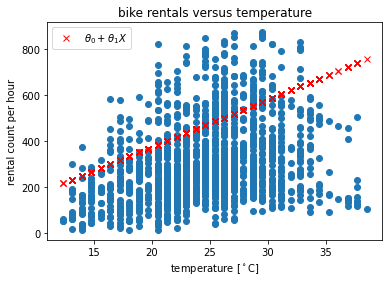

In [13]:
ax = scatterplot_rentals() # draw the mere scatterplot

# now add the regression curve
if (X_train.shape[1] == 2):
    label = r'$\theta_0 + \theta_1 X$'
else:
    label = r'$\theta_0 + \theta_1 X + \theta_2 X^2$'
ax.plot(temps, t, 'rx', label = label) # (r)ed crosses (x)
ax.legend(loc = 'upper left');

At completion of the exercise set the red crosses should be on a quadratic curve with maximum at about 32$^\circ$ C.